# TP — Sélection de variables (refactor)

Notebook simplifié : calcul des scores, histogramme des pertinences, puis comparaison des courbes d'efficacité sur un **unique** graphe.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Données
Charger les données

In [29]:
def _to_numeric_labels(y: pd.Series) -> pd.Series:
    y_num = pd.to_numeric(y, errors="raise")
    if (y_num.dropna() % 1 != 0).any():
        return y_num
    return y_num.astype(int)

In [30]:
def chargement_fichier(f):
    data = pd.read_csv("data/" + f, sep=r"\s+", engine="python", header=None)
    X = data.iloc[:, :-1].astype(float)
    y = _to_numeric_labels(data.iloc[:, -1])

    print("X shape :", X.shape)
    print("y shape :", y.shape)
    return X, y

Découpage de la base d'apprentissage

In [31]:
def decoupage_donnees(X, y, random_state=42):
    X_A, X_T, y_A, y_T = train_test_split(
        X, y, test_size=1/3, stratify=y, random_state=random_state
    )
    print("Taille apprentissage :", X_A.shape)
    print("Taille test :", X_T.shape)
    return X_A, X_T, y_A, y_T

Etiquettage

In [32]:
def rendre_partiellement_etiquete(X_A, y_A, pourcentage_labelise=30, random_state=42):
    if not (0 <= pourcentage_labelise <= 100):
        raise ValueError("pourcentage_labelise doit être entre 0 et 100")

    n = len(y_A)
    n_labelises = int(round((pourcentage_labelise / 100) * n))

    rng = np.random.default_rng(random_state)
    idx = np.arange(n)
    rng.shuffle(idx)
    idx_labelises = idx[:n_labelises]

    # float + NaN est parfait pour mask isna/notna
    y_partiel = pd.Series(np.nan, index=y_A.index, dtype=float)
    y_partiel.iloc[idx_labelises] = y_A.iloc[idx_labelises].astype(float).values

    return X_A, y_partiel

### Selection de variable semi-supervisée

Score de Fischer

In [33]:
import numpy as np
import pandas as pd

# Score de Fisher pour une variable v, calculé uniquement sur la partie labélisée.
def Sv1(X_A, y_partiel, v):
    # Récupérer la colonne v
    if isinstance(v, int):
        x = X_A.iloc[:, v]
    else:
        x = X_A[v]

    # Garder seulement la partie labélisée
    mask_lab = y_partiel.notna()
    x_lab = x.loc[mask_lab].astype(float)
    y_lab = y_partiel.loc[mask_lab]

    if len(y_lab) == 0:
        raise ValueError("Aucune donnée labélisée : impossible de calculer le score de Fisher.")
    
    classes = pd.unique(y_lab)
    if len(classes) < 2:
        raise ValueError("Il faut au moins 2 classes labélisées pour calculer un score de Fisher.")

    # Moyenne globale µ sur la partie labélisée
    mu = x_lab.mean()

    # Calcul du numérateur et du dénominateur
    numerateur = 0.0
    denominateur = 0.0

    for c in classes:
        x_c = x_lab[y_lab == c]
        ni = len(x_c)
        if ni == 0:
            continue

        mu_i = x_c.mean()
        # Ecart-type (population, ddof=0) ; si ni==1 => std=0
        sigma_i = x_c.std(ddof=0)

        numerateur += ni * (mu_i - mu) ** 2
        denominateur += ni * (sigma_i ** 2)

    # Éviter division par zéro
    if denominateur == 0:
        return float("inf") if numerateur > 0 else 0.0

    return numerateur / denominateur


Score Laplacien

In [34]:
import numpy as np
import pandas as pd

# Calcule Sv2(v) sur la partie NON labélisée de A.
def Sv2(X_A, y_partiel, v, t=10.0):
    # Sélection de la partie non labélisée
    mask_unlab = y_partiel.isna()
    X_U = X_A.loc[mask_unlab]
    if X_U.shape[0] < 2:
        raise ValueError("Il faut au moins 2 points non labélisés pour calculer Sv2.")

    # Récupérer la colonne v (sur non labélisé)
    if isinstance(v, int):
        vU = X_U.iloc[:, v].astype(float).to_numpy()
    else:
        vU = X_U[v].astype(float).to_numpy()

    # Variance de v sur non labélisé (population, ddof=0)
    var_v = float(np.var(vU, ddof=0))
    if var_v == 0.0:
        # si var(v)=0, la formule divise par 0 -> on renvoie 0 (ou inf selon ton choix)
        return 0.0

    # Matrices numpy
    Xmat = X_U.to_numpy(dtype=float)   # (n, d)
    n = Xmat.shape[0]

    # ||xi - xj||^2 = ||xi||^2 + ||xj||^2 - 2 xi.xj
    sq_norms = np.sum(Xmat * Xmat, axis=1, keepdims=True)  # (n,1)
    dist2 = sq_norms + sq_norms.T - 2.0 * (Xmat @ Xmat.T)  # (n,n)
    dist2 = np.maximum(dist2, 0.0)  # sécurité numérique

    # Sij
    S = np.exp(-dist2 / float(t))  # (n,n)

    # (vi - vj)^2
    dv2 = (vU.reshape(-1, 1) - vU.reshape(1, -1)) ** 2  # (n,n)

    numerateur = float(np.sum(dv2 * S))
    return numerateur / var_v


Score final

In [35]:
def scoreFinal(X_A, y_partiel, v, t=10.0, eps=1e-12):
    scoreFischer = Sv1(X_A, y_partiel, v)
    scoreLaplace = Sv2(X_A, y_partiel, v, t=t)

    # éviter division par 0 (si Sv2=0)
    if scoreLaplace == 0.0:
        return float("inf") if scoreFischer > 0 else 0.0

    return scoreFischer / (scoreLaplace + eps)

### Evaluation de la sélection

In [36]:
def trier_variables_par_pertinence(X_A, y_partiel, t=10.0, eps=1e-12):
    scores = np.array(
        [scoreFinal(X_A, y_partiel, v, t=t, eps=eps) for v in range(X_A.shape[1])],
        dtype=float
    )
    order = np.argsort(-scores)
    classement = [(int(i), float(scores[i])) for i in order]
    return classement, scores

Efficacité

In [37]:
def _make_mlp_pipeline(normalize=True, hidden_layer_sizes=(100,), max_iter=1000, random_state=42):
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if normalize:
        steps.append(("scaler", StandardScaler()))
    steps.append(("mlp", MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        random_state=random_state
    )))
    return Pipeline(steps)

def courbe_efficacite_mlp_topk(
    X_A, y_A_partiel, X_T, y_T, var_order,
    pas=5, normalize=True,
    hidden_layer_sizes=(100,), max_iter=1000, random_state=42
):
    """
    Courbe accuracy sur T en fonction du nombre de variables (top-k selon var_order),
    k = pas, 2*pas, ..., d (et d à la fin).
    """
    mask_lab = y_A_partiel.notna()
    X_train_full = X_A.loc[mask_lab]
    y_train = y_A_partiel.loc[mask_lab].astype(int)

    if y_train.nunique() < 2:
        raise ValueError("Pas assez de classes dans la partie labélisée. Augmente % labélisées.")

    y_T_int = pd.to_numeric(y_T, errors="raise").astype(int)

    d = len(var_order)
    ks = list(range(pas, d + 1, pas))
    if len(ks) == 0:
        ks = [d]
    elif ks[-1] != d:
        ks.append(d)

    accs = []
    for k in tqdm(ks, desc="Évaluation", leave=True):
        selected = var_order[:k]
        Xtr = X_train_full.iloc[:, selected]
        Xte = X_T.iloc[:, selected]

        model = _make_mlp_pipeline(
            normalize=normalize,
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state
        )
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)
        accs.append(float(accuracy_score(y_T_int, pred)))

    return ks, accs


def courbe_efficacite_mlp_sans_selection_ordre(
    X_A, y_A_partiel, X_T, y_T,
    pas=5, normalize=True,
    hidden_layer_sizes=(100,), max_iter=1000, random_state=42
):
    """
    Courbe "sans sélection" au sens : on prend les variables **dans l'ordre original**
    (v0, v1, v2, ...) puis les k premières : 5, 10, 15, ...
    """
    var_order = list(range(X_A.shape[1]))  # ordre naturel: v0, v1, ...
    return courbe_efficacite_mlp_topk(
        X_A, y_A_partiel, X_T, y_T, var_order,
        pas=pas, normalize=normalize,
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        random_state=random_state
    )


def courbe_perf_vs_pourcentage_labels_kfix(
    filename,
    pourcentages,
    nb_vars_fix=20,
    t=10.0,
    random_state=42,
    normalize=True,
    hidden_layer_sizes=(100,), max_iter=1000
):
    """
    Fixe nb_vars_fix (=20) et calcule la perf (accuracy sur T) en fonction du % labélisé.
    Recalcule le classement à chaque % (car dépend des labels).
    """
    # dépend de ton code existant :
    # chargement_fichier, decoupage_donnees, rendre_partiellement_etiquete, trier_variables_par_pertinence
    X, y = chargement_fichier(filename)
    X_A, X_T, y_A, y_T = decoupage_donnees(X, y, random_state=random_state)

    xs, ys = [], []
    y_T_int = pd.to_numeric(y_T, errors="raise").astype(int)

    for p in pourcentages:
        _, y_A_partiel = rendre_partiellement_etiquete(
            X_A, y_A, pourcentage_labelise=p, random_state=random_state
        )

        classement, _ = trier_variables_par_pertinence(X_A, y_A_partiel, t=t)
        var_order = [vid for (vid, _) in classement]
        k = min(nb_vars_fix, len(var_order))
        selected = var_order[:k]

        mask_lab = y_A_partiel.notna()
        X_train = X_A.loc[mask_lab].iloc[:, selected]
        y_train = y_A_partiel.loc[mask_lab].astype(int)

        # si 1 seule classe, accuracy pas pertinente -> NaN
        if y_train.nunique() < 2:
            xs.append(p)
            ys.append(np.nan)
            continue

        X_test = X_T.iloc[:, selected]

        model = _make_mlp_pipeline(
            normalize=normalize,
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc = float(accuracy_score(y_T_int, pred))

        xs.append(p)
        ys.append(acc)

    return xs, ys

Peformance selon % labelisés

In [38]:
def perf_vs_labeled_pct_top20(
    *,
    X_train_full,
    y_train,
    X_T,
    y_T_int,
    var_order,
    normalize=True,
    hidden_layer_sizes=(100,),
    max_iter=3000,
    random_state=42,
    step_pct=10,
    n_features=20,
    curve_name="Top20 vs % labels"
):
    """
    Évalue la perf (accuracy) en fonction du % de données labélisées,
    en fixant le nombre de variables à n_features (top n_features via var_order).
    """
    # Sélection fixe des 20 variables les plus pertinentes
    selected = var_order[:n_features]
    Xtr_all = X_train_full.iloc[:, selected]
    Xte = X_T.iloc[:, selected]

    # Prépare les pourcentages
    pcts = list(range(0, 101, step_pct))
    accs = []

    # Barre de chargement
    for pct in tqdm(pcts, desc=f"Évaluation — {curve_name}", leave=True):
        frac = pct / 100.0

        # 0% labels : baseline "classe majoritaire" (pas d'entraînement possible)
        if frac <= 0.0:
            majority = int(np.bincount(np.asarray(y_train, dtype=int)).argmax())
            pred = np.full(shape=len(y_T_int), fill_value=majority, dtype=int)
            accs.append(float(accuracy_score(y_T_int, pred)))
            continue

        # Sous-ensemble labélisé (stratifié si possible)
        n = max(1, int(round(frac * len(Xtr_all))))

        if n >= len(Xtr_all):
            X_sub, y_sub = Xtr_all, y_train
        else:
            sss = StratifiedShuffleSplit(
                n_splits=1,
                train_size=n,
                random_state=random_state + pct
            )
            (idx_sub, _), = sss.split(Xtr_all, y_train)
            X_sub = Xtr_all.iloc[idx_sub]
            y_sub = np.asarray(y_train)[idx_sub]

        # Fit + eval
        model = _make_mlp_pipeline(
            normalize=normalize,
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state
        )
        model.fit(X_sub, y_sub)
        pred = model.predict(Xte)
        accs.append(float(accuracy_score(y_T_int, pred)))

    # --- Plot histogramme
    plt.figure()
    plt.bar([str(p) for p in pcts], accs)
    plt.xlabel("% de données labélisées")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs % labels (Top {n_features} variables)")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return {"pcts": pcts, "accs": accs, "selected": selected}


## Visualisations

1) Histogramme des scores de pertinence (score final)

2) Courbes d'efficacité (toutes sur un seul graphe)

In [39]:
import matplotlib.pyplot as plt

def plot_hist_scores(scores, title="Pertinence des variables (score final)"):
    """Histogramme : v0, v1, ... -> score final."""
    d = len(scores)
    x = list(range(d))
    labels = [f"v{i}" for i in x]

    plt.figure(figsize=(12, 4))
    plt.bar(x, scores)
    plt.title(title)
    plt.xlabel("Variable")
    plt.ylabel("Score final")
    plt.xticks(x, labels, rotation=90)
    plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


def plot_courbes_efficacite(curves_k, title="Courbes d'efficacité (MLP)"):
    """
    Trace TOUTES les courbes accuracy(k) sur un seul graphe.
    curves_k : dict nom -> (ks, accs)
    """
    plt.figure(figsize=(10, 5))
    for name, (ks, accs) in curves_k.items():
        plt.plot(ks, accs, marker="o", label=name)

    plt.title(title)
    plt.xlabel("Nombre de variables (k)")
    plt.ylabel("Accuracy sur T")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Exécution

Lance le pipeline sur le fichier de données.

In [ ]:
def pipeline_plots_efficacite(
    filename,
    pourcentage_labelise=30,
    t=10.0,
    pas=5,
    random_state=42,
    hidden_layer_sizes=(100,),
    max_iter=1000
):
    """
    1) Charge et découpe les données (A/T)
    2) Rend A partiellement labélisé
    3) Calcule le score final par variable + classement
    4) Figure 1 : histogramme des scores
    5) Figure 2 : toutes les courbes accuracy(k) sur un seul graphe
    6) Figure 3 : histogramme accuracy en fonction du % de données labélisées (Top 20 variables)
    """
    # 0) Data + split
    X, y = chargement_fichier(filename)
    X_A, X_T, y_A, y_T = decoupage_donnees(X, y, random_state=random_state)

    # Conversion éventuelle de y_T en int (cohérent avec le reste du notebook)
    y_T_int = np.asarray(y_T, dtype=int)

    # 1) Partiellement labélisé (sert pour les courbes k)
    _, y_A_partiel = rendre_partiellement_etiquete(
        X_A, y_A, pourcentage_labelise=pourcentage_labelise, random_state=random_state
    )

    # 2) Classement pertinence + scores bruts (score final)
    classement, scores = trier_variables_par_pertinence(X_A, y_A_partiel, t=t)
    var_order_pert = [vid for (vid, _) in classement]
    var_order_nonpert = list(reversed(var_order_pert))
    var_order_ordre = list(range(X_A.shape[1]))  # v0..v(n-1) (sans sélection)

    # 3) Figure 1 : histogramme des scores (dans l'ordre v0, v1, ...)
    plot_hist_scores(scores)

    # 4) Figure 2 : toutes les courbes accuracy(k) sur un seul graphe
    curves_k = {
        "Pertinentes (norm)": courbe_efficacite_mlp_topk(
            X_A, y_A_partiel, X_T, y_T, var_order_pert,
            pas=pas, normalize=True,
            hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
        ),
        "Pertinentes (non-norm)": courbe_efficacite_mlp_topk(
            X_A, y_A_partiel, X_T, y_T, var_order_pert,
            pas=pas, normalize=False,
            hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
        ),
        "Non-pertinentes (norm)": courbe_efficacite_mlp_topk(
            X_A, y_A_partiel, X_T, y_T, var_order_nonpert,
            pas=pas, normalize=True,
            hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
        ),
        "Sans sélection (norm)": courbe_efficacite_mlp_topk(
            X_A, y_A_partiel, X_T, y_T, var_order_ordre,
            pas=pas, normalize=True,
            hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
        ),
        # "Sans sélection (non-norm)": courbe_efficacite_mlp_topk(
        #     X_A, y_A_partiel, X_T, y_T, var_order_ordre,
        #     pas=pas, normalize=False,
        #     hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
        # ),
    }

    plot_courbes_efficacite(curves_k)

    # 5) Figure 3 : accuracy vs % labels (Top 20 variables)
    #    IMPORTANT : on évalue selon % labels sur A (pas sur y_A_partiel fixe),
    #    donc on repasse y_A complet ici.
    results_pct = perf_vs_labeled_pct_top20(
        X_train_full=X_A,
        y_train=np.asarray(y_A, dtype=int),
        X_T=X_T,
        y_T_int=y_T_int,
        var_order=var_order_pert,   # top variables d'après le classement
        normalize=True,             # tu peux changer si tu veux comparer norm/non-norm
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        random_state=random_state,
        step_pct=10,
        n_features=20,
        curve_name="Top20 — % labels"
    )

    return {
        "scores": scores,
        "classement": classement,
        "curves_k": curves_k,
        "results_pct": results_pct
    }


X shape : (5000, 40)
y shape : (5000,)
Taille apprentissage : (3333, 40)
Taille test : (1667, 40)


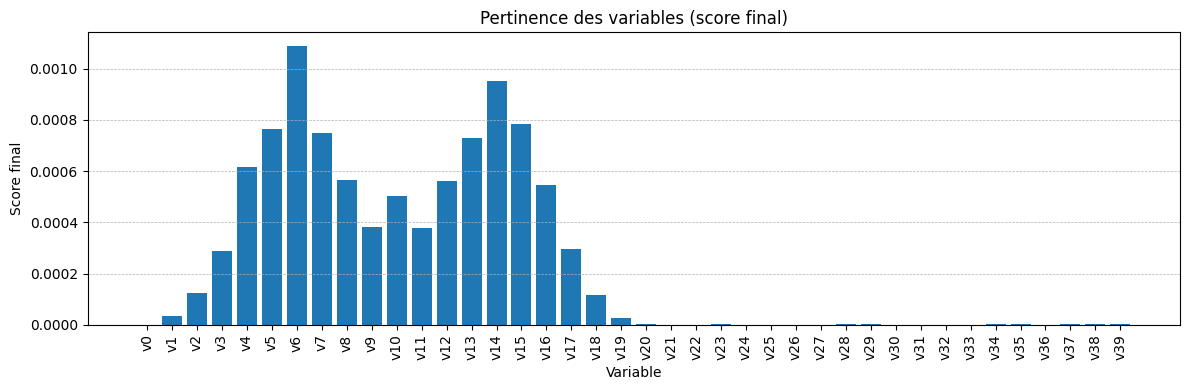

Évaluation:   0%|          | 0/8 [00:00<?, ?it/s]

Évaluation:   0%|          | 0/8 [00:00<?, ?it/s]

Évaluation:   0%|          | 0/8 [00:00<?, ?it/s]

Évaluation:   0%|          | 0/8 [00:00<?, ?it/s]

Évaluation:   0%|          | 0/8 [00:00<?, ?it/s]

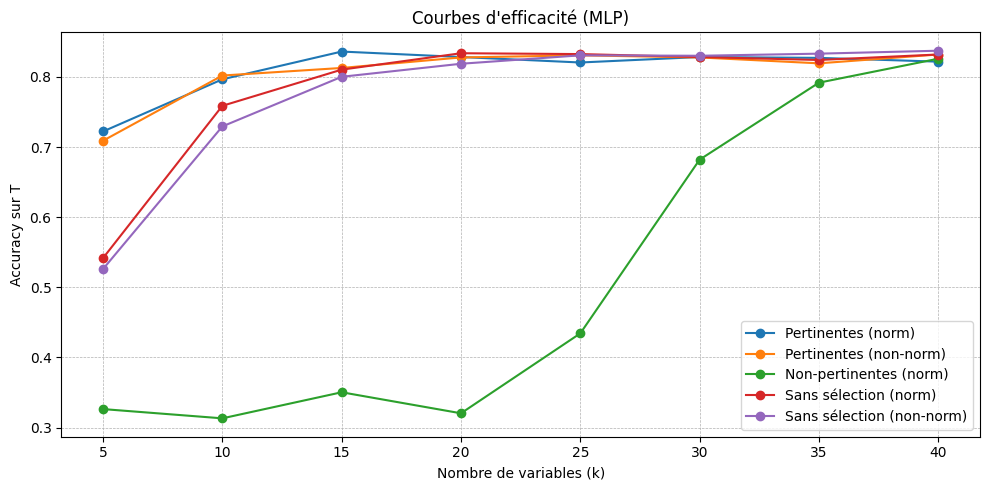

Évaluation — Top20 — % labels:   0%|          | 0/11 [00:00<?, ?it/s]

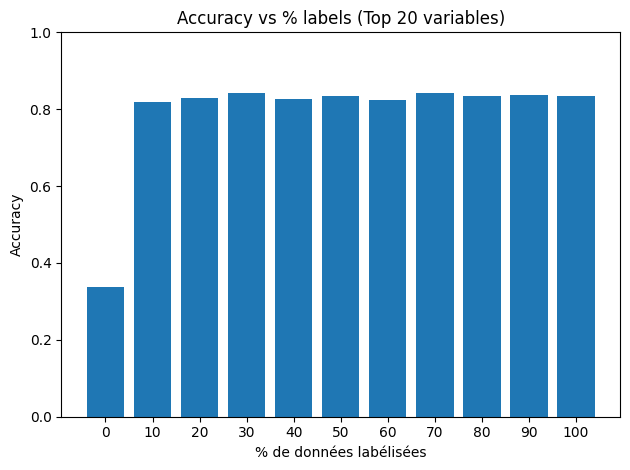

In [41]:
out = pipeline_plots_efficacite(filename="wave.txt")